# Assessment 02

Eurico Martins (nº. 8794, a8794@alunos.ipca.pt)
Gutelvam Fernandes (nº. 33791,  a33791@alunos.ipca.pt)

In [239]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [240]:
from enum import Enum

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import confusion_matrix, silhouette_samples

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)


In [241]:
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [242]:
class MissingValuesStrategy(Enum):
	MEAN="mean"
	MEDIAN = "median"
	MODE = "mode"
	CONSTANT = "constant"

In [243]:
class DataPreparation:
	def __init__(self, file_path=None, target_column=None):
		if not file_path:
			raise ValueError("Either 'file_path' or 'dataframe' must be provided.")

		self.df = pd.read_csv(file_path)
		self._print_summary(file_path)
		
		self.original_df = self.df.copy(True)
		self.target_column = target_column

		if self.target_column and self.target_column not in self.df.columns:
			raise ValueError(f"Target column '{target_column}' not found in the dataset.")
		

	def drop_columns(self, columns_to_drop):
		if not isinstance(columns_to_drop, list):
				raise ValueError("columns_to_drop should be a list of column names.")

		# Check if any columns in the list do not exist in the DataFrame
		missing_columns = [col for col in columns_to_drop if col not in self.df.columns]
		if missing_columns:
				raise ValueError(f"The following columns are not found in the dataset: {', '.join(missing_columns)}")

		# Drop the columns from the DataFrame
		self.df.drop(columns=columns_to_drop, inplace=True)
		print(f"Columns {', '.join(columns_to_drop)} dropped successfully.")


	def handle_missing_values(self, strategy:MissingValuesStrategy = MissingValuesStrategy.MEAN, fill_value=None):
		for column in self.df.columns:
			if self.df[column].isnull().sum() > 0:
				if strategy == MissingValuesStrategy.MEAN and self.df[column].dtype in ["float64", "int64"]:
					self.df[column].fillna(self.df[column].mean(), inplace=True)
				elif strategy == MissingValuesStrategy.MEDIAN and self.df[column].dtype in ["float64", "int64"]:
					self.df[column].fillna(self.df[column].median(), inplace=True)
				elif strategy == MissingValuesStrategy.MODE:
					self.df[column].fillna(self.df[column].mode()[0], inplace=True)
				elif strategy == MissingValuesStrategy.CONSTANT:
					self.df[column].fillna(fill_value, inplace=True)

	def encode_categorical(self):
		self.label_encoders = {}
		for column in self.df.select_dtypes(include=["object", "category"]).columns:
			le = LabelEncoder()
			self.df[column] = le.fit_transform(self.df[column])
			self.label_encoders[column] = le

	def get_features_and_target(self):
		if not self.target_column:
			raise ValueError("Target column is not specified.")
		X = self.df.drop(columns=[self.target_column])
		y = self.df[self.target_column]
		return X, y

	def scale_features(self):
		columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		scaler = StandardScaler()
		self.df[columns] = scaler.fit_transform(self.df[columns])


	def remove_outliers(self, columns=None, factor=1.5, threshold=3):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		# Determine if the data is skewed or normal
		skewed_columns = self._detect_distribution(columns)
		if skewed_columns:
				print(f"Using IQR method for skewed columns: {skewed_columns}")
				rows_removed = self._remove_outliers_iqr(columns=skewed_columns, factor=factor)
		else:
				print("Using Z-score method for normally distributed columns.")
				rows_removed = self._remove_outliers_zscore(columns=columns, threshold=threshold)

		print(f"Rows removed: {rows_removed}")

	def remove_duplicates(self, subset=None, keep="first"):
		rows_before = len(self.df)
		self.df.drop_duplicates(subset=subset, keep=keep, inplace=True)
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		print(f"Rows removed due to duplicates: {removed_rows}")
		return removed_rows


	def plot_distributions(self):
		# Distribution plots for numerical features
		numerical_columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		n_cols = 3  # Number of plots in each row
		n_rows = (len(numerical_columns) // n_cols) + (1 if len(numerical_columns) % n_cols else 0)

		# Adjust the plot size
		plt.figure(figsize=(12, 4 * n_rows))
		for idx, column in enumerate(numerical_columns):
				plt.subplot(n_rows, n_cols, idx + 1)
				sns.histplot(self.df[column], kde=True, bins=30)
				plt.title(f'Distribution of {column}')
		# Apply tight layout for better spacing
		plt.tight_layout()
		plt.show()

	def normality_test_with_plots(self):
		# Select numerical columns
		evaluation_columns = self.df.select_dtypes(include=['int64', 'float64']).columns

		# Loop through each numeric column
		for column in evaluation_columns:
				_, axes = plt.subplots(1, 2, figsize=(10, 5))

				# Plot Histogram and KDE
				sns.histplot(self.df[column], kde=True, color='blue', stat='density', bins=30, ax=axes[0])
				axes[0].set_title(f"Histogram and KDE of {column}", fontsize=12)
				axes[0].set_xlabel(column, fontsize=10)
				axes[0].set_ylabel("Density", fontsize=10)

				# Q-Q Plot
				stats.probplot(self.df[column], dist="norm", plot=axes[1])
				axes[1].set_title(f"Q-Q Plot of {column}", fontsize=16)

				# Adjust layout to avoid overlap
				plt.tight_layout()
				plt.show()

	def plot_correlation_matrix(self, columns=None, annot=True, cmap="coolwarm"):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		# Calculate the correlation matrix
		correlation_matrix = self.df[columns].corr()

		plt.figure(figsize=(10, 6))
		sns.heatmap(correlation_matrix, annot=annot, cmap=cmap, fmt='.2f', linewidths=0.5, cbar=True)
		plt.title("Correlation Matrix")
		plt.show()

	def normality_test(self, columns=None):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		for column in columns:
			stat_shapiro, p_value_shapiro = stats.shapiro(self.df[column].dropna())
			print(f"Shapiro-Wilk Test for {column}: stat={stat_shapiro}, p-value={p_value_shapiro}")

			stat_ks, p_value_ks = stats.kstest(self.df[column].dropna(), 'norm', args=(self.df[column].mean(), self.df[column].std()))
			print(f"Kolmogorov-Smirnov Test for {column}: stat={stat_ks}, p-value={p_value_ks}")

			# Plot histogram with KDE and normal distribution fit for visual inspection
			plt.figure(figsize=(10, 6))
			sns.histplot(self.df[column], kde=True, bins=30, color='blue', stat="density")
			min_value, max_value = self.df[column].min(), self.df[column].max()
			x = np.linspace(min_value, max_value, 100)
			y = stats.norm.pdf(x, loc=self.df[column].mean(), scale=self.df[column].std())
			plt.plot(x, y, color='red', label='Normal Distribution Fit')
			plt.title(f'{column} Distribution with Normality Test')
			plt.legend()
			plt.show()


	def compare_histograms(self):
			# Original data vs current data (after processing)
			numerical_columns = self.df.select_dtypes(include=["float64", "int64"]).columns
			for column in numerical_columns:
					plt.figure(figsize=(10, 6))
					sns.histplot(self.original_df[column], kde=True, color='blue', label='Original Data', bins=30)
					sns.histplot(self.df[column], kde=True, color='red', label='Processed Data', bins=30)
					plt.legend()
					plt.title(f'Comparison of {column} Histogram: Original vs Processed')
					plt.show()

	def summary(self):
		summ = pd.DataFrame(self.df.dtypes, columns=['Data Type'])
		summ['Missing#'] = self.df.isna().sum()
		summ['Missing%'] = (self.df.isna().sum())/len(self.df)
		summ['Dups'] = self.df.duplicated().sum()
		summ['Uniques'] = self.df.nunique().values
		summ['Count'] = self.df.count().values
		
		desc = pd.DataFrame(self.df.describe(include='all').transpose())

		summ['Min'] = desc['min'].values
		summ['Max'] = desc['max'].values
		summ['Average'] = desc['mean'].values
		summ['Standard Deviation'] = desc['std'].values
		summ['First Value'] = self.df.loc[0].values
		summ['Second Value'] = self.df.loc[1].values
		summ['Third Value'] = self.df.loc[2].values

		display(summ)

	def _print_summary(self,path:str):
		print(f"Loaded data from ({path})\n")
		print(f'data shape: {self.df.shape}')

		summ = pd.DataFrame(self.df.dtypes, columns=['Data Type'])
		summ['Missing#'] = self.df.isna().sum()
		summ['Missing%'] = (self.df.isna().sum())/len(self.df)
		summ['Dups'] = self.df.duplicated().sum()
		summ['Uniques'] = self.df.nunique().values
		summ['Count'] = self.df.count().values
		
		desc = pd.DataFrame(self.df.describe(include='all').transpose())

		summ['Min'] = desc['min'].values
		summ['Max'] = desc['max'].values
		summ['Average'] = desc['mean'].values
		summ['Standard Deviation'] = desc['std'].values
		summ['First Value'] = self.df.loc[0].values
		summ['Second Value'] = self.df.loc[1].values
		summ['Third Value'] = self.df.loc[2].values

		display(summ)


	def _detect_distribution(self, columns=None):
		if columns is None:
				columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		# Check for skewness in the data to decide the method
		skewness = self.df[columns].skew()
		skewed_columns = skewness[skewness.abs() > 0.5].index.tolist()
		return skewed_columns
	
	def _remove_outliers_iqr(self, columns=None, factor=1.5):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		rows_before = len(self.df)
		for column in columns:
			Q1 = self.df[column].quantile(0.25)
			Q3 = self.df[column].quantile(0.75)
			IQR = Q3 - Q1
			lower_bound = Q1 - factor * IQR
			upper_bound = Q3 + factor * IQR
			self.df = self.df[(self.df[column] >= lower_bound) & (self.df[column] <= upper_bound)]
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		return removed_rows

	def _remove_outliers_zscore(self, columns=None, threshold=3):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		rows_before = len(self.df)
		z_scores = np.abs(stats.zscore(self.df[columns]))
		self.df = self.df[(z_scores < threshold).all(axis=1)]
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		return removed_rows

## PipeLine Object Definition

In [244]:
class LearningType(Enum):
    SUPERVISED = "supervised"
    UNSUPERVISED = "unsupervised"


class TargetMetric(Enum):
    RMSE = "rmse"
    MSE = "mse"
    MAE = "mae"
    R2 = "r2"
    ACCURACY = "accuracy"
    SILHOUETTE = "silhouette"
    PRECISION = "precision"
    RECALL = "recall"

In [245]:
class AutoMLPipeline:
	def __init__(self, learning_type: LearningType, target_metric: TargetMetric):
		if not isinstance(learning_type, LearningType):
				raise ValueError("learning_type must be an instance of LearningType Enum.")
		if not isinstance(target_metric, TargetMetric):
				raise ValueError("target_metric must be an instance of TargetMetric Enum.")
		
		# Validate that the metric is appropriate for the learning type
		valid_metrics = {
				LearningType.SUPERVISED: {
						TargetMetric.RMSE,
						TargetMetric.MSE,
						TargetMetric.MAE,
						TargetMetric.R2,
						TargetMetric.ACCURACY,
						TargetMetric.PRECISION,
						TargetMetric.RECALL,
				},
				LearningType.UNSUPERVISED: {
						TargetMetric.SILHOUETTE,
				},
		}
		
		if target_metric not in valid_metrics[learning_type]:
				raise ValueError(
						f"Invalid target metric '{target_metric.name}' for learning type '{learning_type.name}'. "
						f"Valid metrics for {learning_type.name} are: "
						f"{', '.join(metric.name for metric in valid_metrics[learning_type])}."
				)
		
		self.learning_type = learning_type
		self.target_metric = target_metric

		self.pipeline = None

		self.best_model = None
		self.results = {}


	def train(self, x, y):
		if self.learning_type == LearningType.SUPERVISED and y is None:
			raise ValueError("y is required for supervised learning.")

		numeric_features = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
		categorical_features = x.select_dtypes(include=["object", "category"]).columns.tolist()

		if self.learning_type == LearningType.SUPERVISED:
			self._train_supervised(x, y,numeric_features, categorical_features)


	def report(self):
		if not self.results:
				raise ValueError("No results available. Train the models first.")

		# Convert results dictionary to DataFrame
		results_df = pd.DataFrame(self.results.items(), columns=["Model", "Score"])
		results_df = results_df.sort_values(by="Score", ascending=(self.target_metric != TargetMetric.R2))

		# Print the summary table
		print("\nModel Performance Summary:")
		print(results_df)

		# Plot model performance comparison
		plt.figure(figsize=(10, 6))
		sns.barplot(x="Score", y="Model", data=results_df, palette="viridis")
		plt.title(f"Model Performance Comparison ({self.target_metric.name})", fontsize=16)
		plt.xlabel("Score", fontsize=14)
		plt.ylabel("Model", fontsize=14)
		plt.tight_layout()
		plt.show()

		# Details for the best model
		print(f"\nBest Model: {results_df.iloc[0]['Model']}")
		if self.learning_type == LearningType.SUPERVISED:
				self._report_supervised()
		elif self.learning_type == LearningType.UNSUPERVISED:
				self._report_unsupervised()


	def _create_pipeline(self, model, numeric_features, categorical_features):
		# Define transformers for numeric and categorical data
		numeric_transformer = Pipeline(steps=[
				("scaler", StandardScaler())
		])
		categorical_transformer = Pipeline(steps=[
				("onehot", OneHotEncoder(handle_unknown="ignore"))
		])
		
		# Create a preprocessor for column transformations
		preprocessor = ColumnTransformer(
				transformers=[
						("num", numeric_transformer, numeric_features),
						("cat", categorical_transformer, categorical_features),
				]
		)
		
		# Create the full pipeline
		self.pipeline = Pipeline(steps=[
				("preprocessor", preprocessor),
				("model", model)
		])


	def _train_supervised(self, x, y, numeric_features, categorical_features):
		if self.learning_type == LearningType.SUPERVISED:
			models = [
				("Random Forest", RandomForestRegressor() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else RandomForestClassifier(), {
					"model__n_estimators": randint(10, 200),
					"model__max_depth": randint(3, 20),
				}),
				("Linear/Logistic Regression", LinearRegression() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else LogisticRegression(), {}),
				("Decision Tree", DecisionTreeRegressor() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else DecisionTreeClassifier(), {
					"model__max_depth": randint(3, 20),
					"model__min_samples_split": randint(2, 10),
					"model__min_samples_leaf": randint(1, 5),
				}),
				("Support Vector Machine", SVR() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else SVC(probability=True), {
					"model__C": uniform(0.1, 10),
					"model__gamma": uniform(0.01, 1),
				}),
			]
			x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

			best_score = -np.inf if self.target_metric == TargetMetric.R2 else np.inf
			for name, model, param_grid in models:
				# Create the pipeline
				self._create_pipeline(model, numeric_features, categorical_features)

				# Define the scorer based on the target metric
				scorer = None
				match self.target_metric:
					case TargetMetric.RMSE:
						scorer = "neg_root_mean_squared_error"
					case TargetMetric.MSE:
						scorer = "neg_mean_squared_error"
					case TargetMetric.MAE:
						scorer = "neg_mean_absolute_error"
					case TargetMetric.R2:
						scorer = "r2"
					case TargetMetric.ACCURACY:
						scorer = "accuracy"
					case TargetMetric.PRECISION:
						scorer = "precision_weighted"
					case TargetMetric.RECALL:
						scorer = "recall_weighted"

				# Perform randomized search
				search = RandomizedSearchCV(
					self.pipeline,
					param_distributions=param_grid,
					scoring=scorer,
					cv=5,
					n_iter=10,
					random_state=42,
					n_jobs=-1,
				)
				search.fit(x_train, y_train)

				# Retrieve the best pipeline and score
				best_pipeline = search.best_estimator_
				y_pred = best_pipeline.predict(x_test)
				score = search.best_score_

				# Update the best model
				if (self.target_metric == TargetMetric.R2 and score > best_score) or (self.target_metric != TargetMetric.R2 and score < best_score):
					best_score = score
					self.best_model = best_pipeline
					self.results = {name: score}


	def _report_supervised(self):
		x_test = self.best_model.named_steps["preprocessor"].transform(self.best_model.named_steps["model"].data_)
		y_test = self.best_model.named_steps["model"].y_test
		y_pred = self.best_model.predict(x_test)

		if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2}:
			# Residual Plot for Regression
			residuals = y_test - y_pred
			plt.figure(figsize=(10, 6))
			sns.scatterplot(x=y_pred, y=residuals)
			plt.axhline(0, color="red", linestyle="--", linewidth=1.5)
			plt.title("Residuals Plot", fontsize=16)
			plt.xlabel("Predicted Values", fontsize=14)
			plt.ylabel("Residuals", fontsize=14)
			plt.tight_layout()
			plt.show()
		else:
			# Confusion Matrix for Classification
			cm = confusion_matrix(y_test, y_pred)
			plt.figure(figsize=(8, 6))
			sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.best_model.classes_, yticklabels=self.best_model.classes_)
			plt.title("Confusion Matrix", fontsize=16)
			plt.xlabel("Predicted", fontsize=14)
			plt.ylabel("Actual", fontsize=14)
			plt.tight_layout()
			plt.show()


	def _report_unsupervised(self):
		x_transformed = self.best_model.named_steps["preprocessor"].transform(self.best_model.named_steps["model"].data_)
		labels = self.best_model.predict(x_transformed)

		# Silhouette Coefficient Distribution
		silhouette_vals = silhouette_samples(x_transformed, labels)
		plt.figure(figsize=(10, 6))
		sns.histplot(silhouette_vals, kde=True, bins=30, color="blue")
		plt.title("Silhouette Coefficients Distribution", fontsize=16)
		plt.xlabel("Silhouette Coefficient", fontsize=14)
		plt.ylabel("Frequency", fontsize=14)
		plt.tight_layout()
		plt.show()

		# Cluster Visualization (optional, works with 2D data)
		if x_transformed.shape[1] == 2:  # Only visualize if data is 2D
			plt.figure(figsize=(10, 6))
			sns.scatterplot(x=x_transformed[:, 0], y=x_transformed[:, 1], hue=labels, palette="viridis", s=50)
			plt.title("Cluster Visualization", fontsize=16)
			plt.xlabel("Feature 1", fontsize=14)
			plt.ylabel("Feature 2", fontsize=14)
			plt.legend(title="Cluster", loc="best")
			plt.tight_layout()
			plt.show()

## Main

DataBase loading and metadata display

In [246]:
airbnb_data_prep:DataPreparation = DataPreparation("../data/learning/airbnb_lisbon/airbnb_lisbon_1480_2017-07-27.csv", target_column="price")

airbnb_data_prep.drop_columns(["survey_id","room_id","last_modified", "country", "city", "borough", "bathrooms", "minstay"])

airbnb_data_prep.handle_missing_values(MissingValuesStrategy.MEAN)
airbnb_data_prep.encode_categorical()
airbnb_data_prep.scale_features()
airbnb_data_prep.remove_outliers()
airbnb_data_prep.remove_duplicates(subset=None, keep="first")

airbnb_data_prep.summary()
# airbnb_data_frame: pd.DataFrame = load_data_and_inspect(airbnb_ds_path, sep=',')

# d_X = airbnb_data_frame.drop(['price'], axis=1)
# d_y = airbnb_data_frame.price

# autoML = AutoMLPipeline(LearningType.SUPERVISED, TargetMetric.RMSE)
# autoML.train(d_X, d_y)

Loaded data from (../data/learning/airbnb_lisbon/airbnb_lisbon_1480_2017-07-27.csv)

data shape: (13578, 20)


,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,First Value,Second Value,Third Value
room_id,int64,0,0.000000,0,13578,13578,6499.0,20091030.0,11286530.758285,6331112.119502,14708916,7465447,11058290
survey_id,int64,0,0.000000,0,1,13578,1480.0,1480.0,1480.0,0.0,1480,1480,1480
host_id,int64,0,0.000000,0,6457,13578,14455.0,142658216.0,40317799.948814,41202576.060598,91501272,704061,1379661
room_type,object,0,0.000000,0,3,13578,NaN,NaN,NaN,NaN,Shared room,Shared room,Shared room
country,float64,13578,1.000000,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,object,0,0.000000,0,1,13578,NaN,NaN,NaN,NaN,Lisbon,Lisbon,Lisbon
borough,float64,13578,1.000000,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood,object,0,0.000000,0,24,13578,NaN,NaN,NaN,NaN,Santo António,Avenidas Novas,Santa Maria Maior
reviews,int64,0,0.000000,0,276,13578,0.0,448.0,29.507512,43.657402,19,4,38
overall_satisfaction,float64,0,0.000000,0,9,13578,0.0,5.0,3.242046,2.151046,4.5,3.5,4.5


Columns survey_id, room_id, last_modified, country, city, borough, bathrooms, minstay dropped successfully.
Using IQR method for skewed columns: ['host_id', 'room_type', 'reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'price', 'latitude', 'longitude']
Rows removed: 3516
Rows removed due to duplicates: 0


,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,First Value,Second Value,Third Value
host_id,float64,0,0.0,0,4914,10062,-0.978147,2.483454,0.051594,1.008123,1.242285,-0.961474,-0.945076
room_type,float64,0,0.0,0,3,10062,-0.588193,3.624086,0.047710,1.024525,3.624086,3.624086,3.624086
neighborhood,float64,0,0.0,0,16,10062,-1.874024,1.297131,0.044422,0.992460,1.008845,-1.297450,0.864701
reviews,float64,0,0.0,0,99,10062,-0.675913,1.568921,-0.196559,0.567192,-0.240690,-0.584287,0.194533
overall_satisfaction,float64,0,0.0,0,9,10062,-1.507251,0.817286,0.003074,0.994653,0.584832,0.119925,0.584832
accommodates,float64,0,0.0,0,9,10062,-1.274210,2.273940,-0.168499,0.727572,0.056346,0.943384,1.830421
bedrooms,float64,0,0.0,0,4,10062,-1.472761,1.404113,-0.177949,0.694158,-0.513803,-0.513803,-0.513803
price,float64,0,0.0,0,139,10062,-0.637002,0.671516,-0.153380,0.262862,-0.474453,-0.401306,-0.401306
name,float64,0,0.0,0,9916,10062,-1.733947,1.726510,0.011274,0.998158,0.091945,1.042352,-1.097749
latitude,float64,0,0.0,0,8393,10062,-1.593979,1.929338,-0.115749,0.650552,0.205146,0.936901,-0.340730


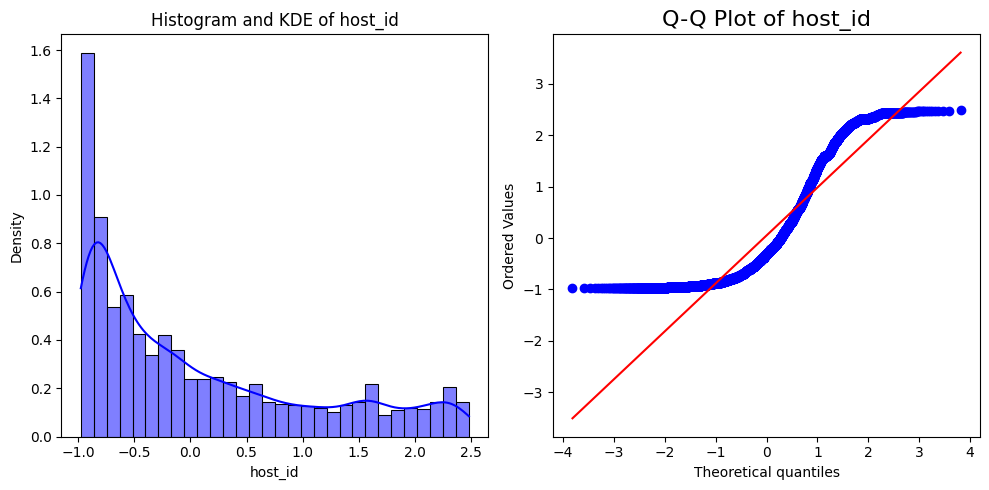

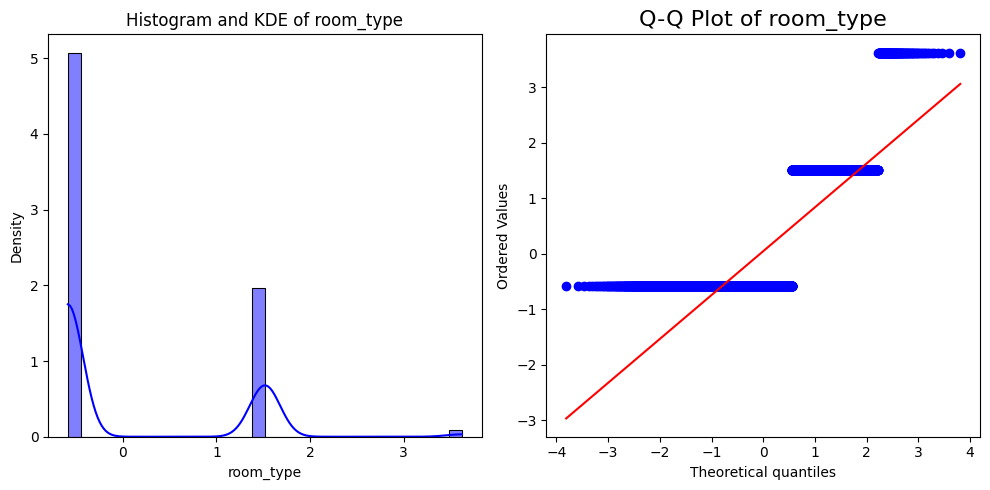

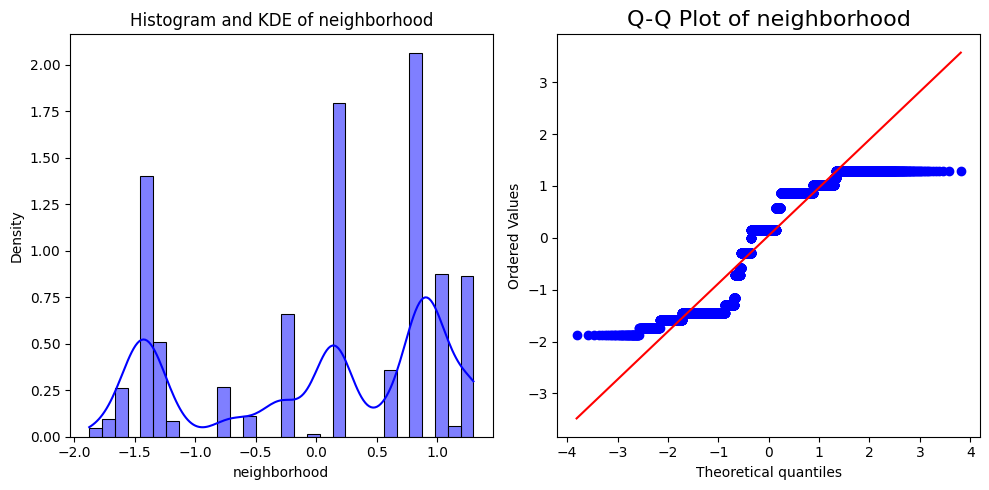

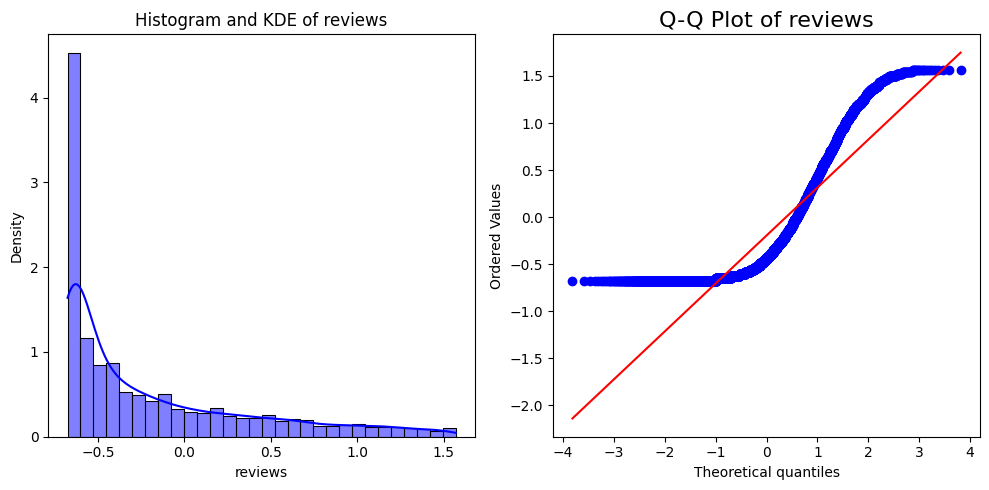

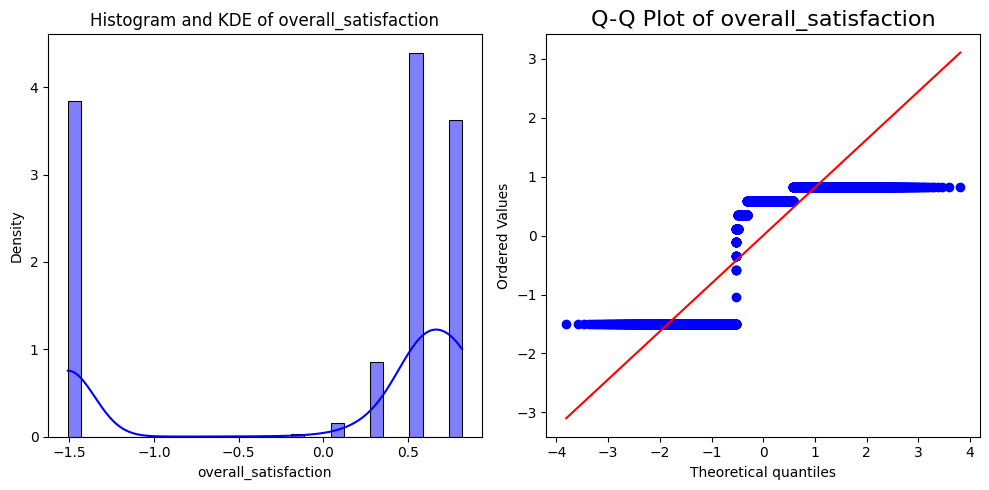

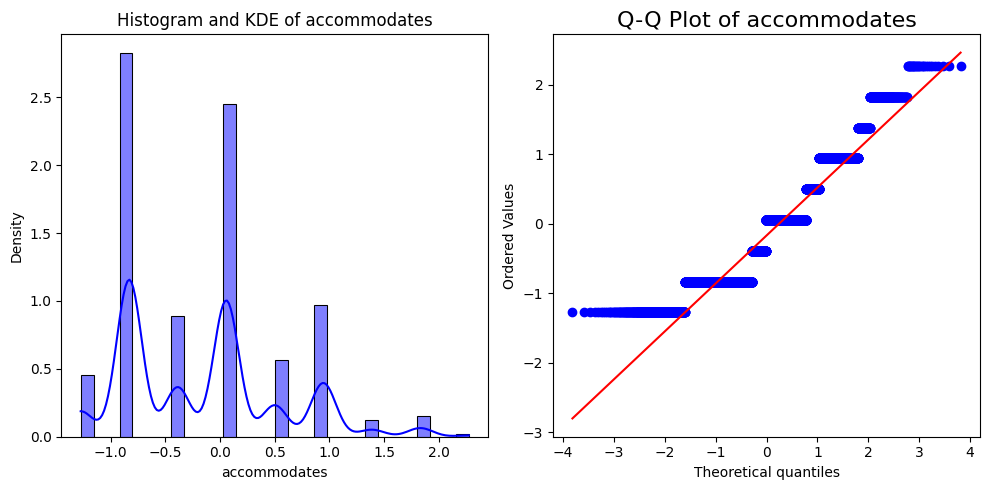

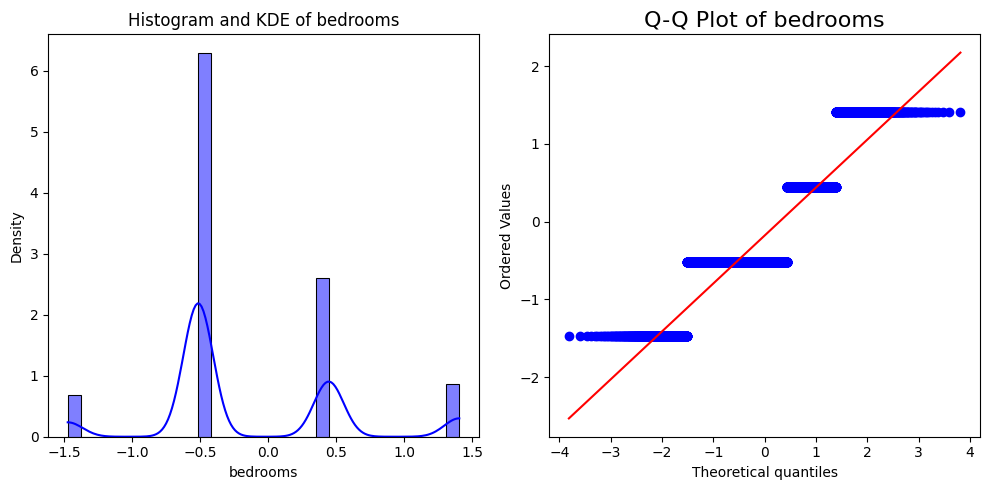

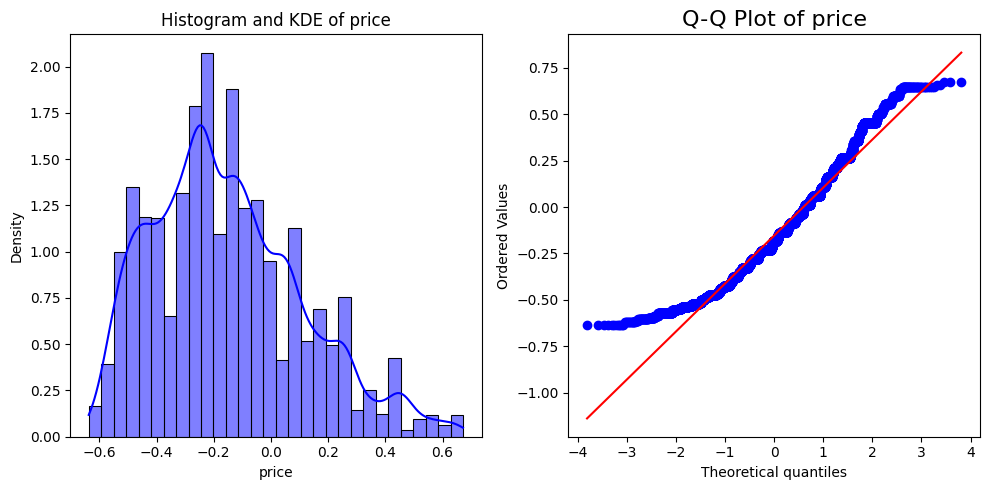

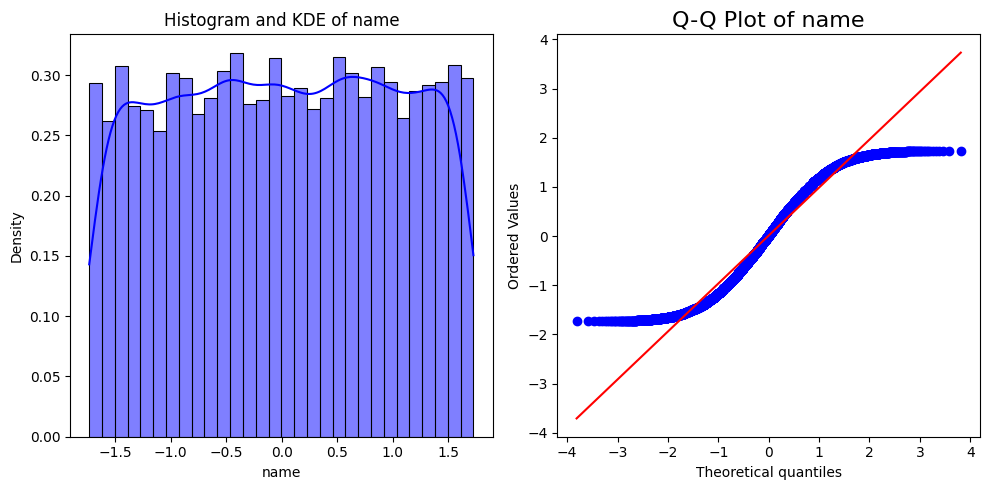

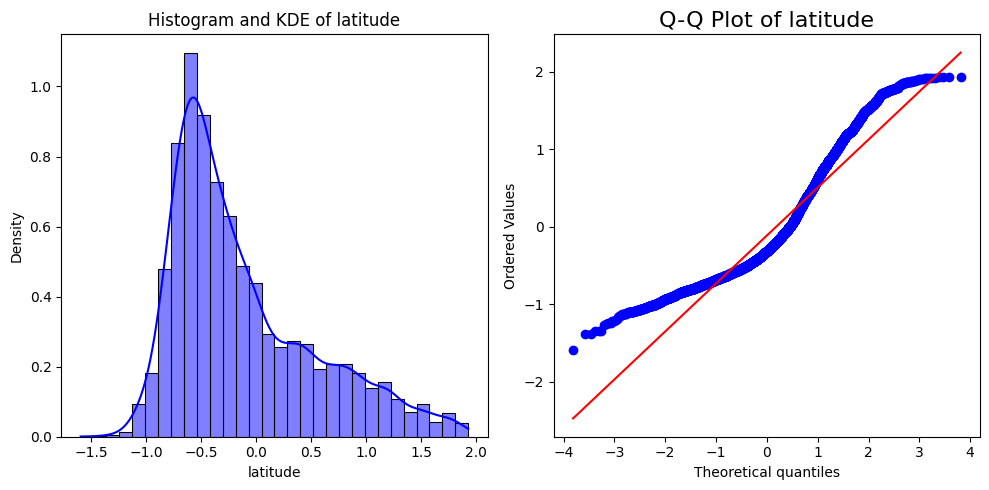

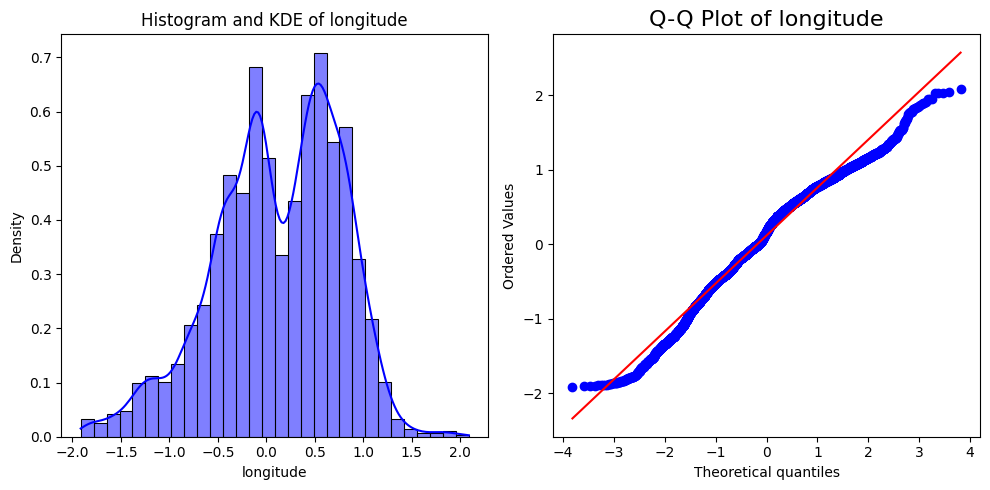

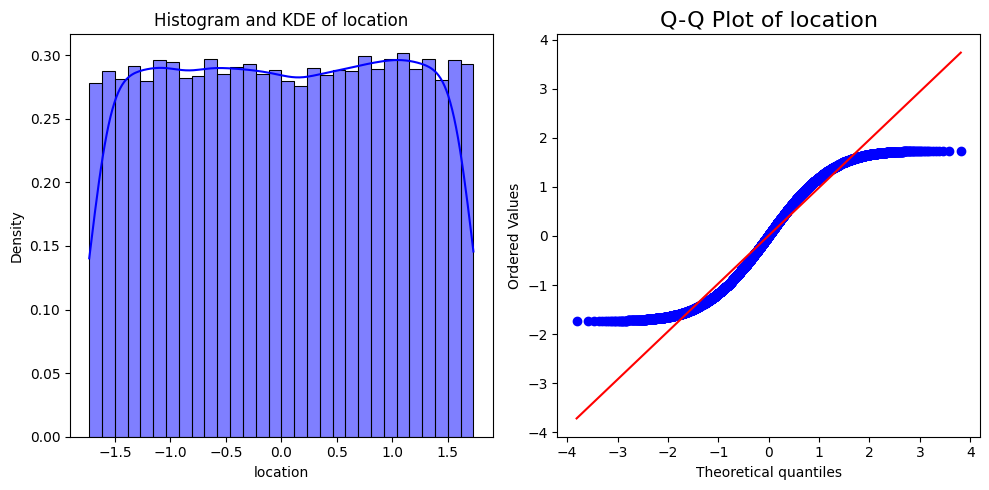

In [247]:
airbnb_data_prep.normality_test_with_plots()

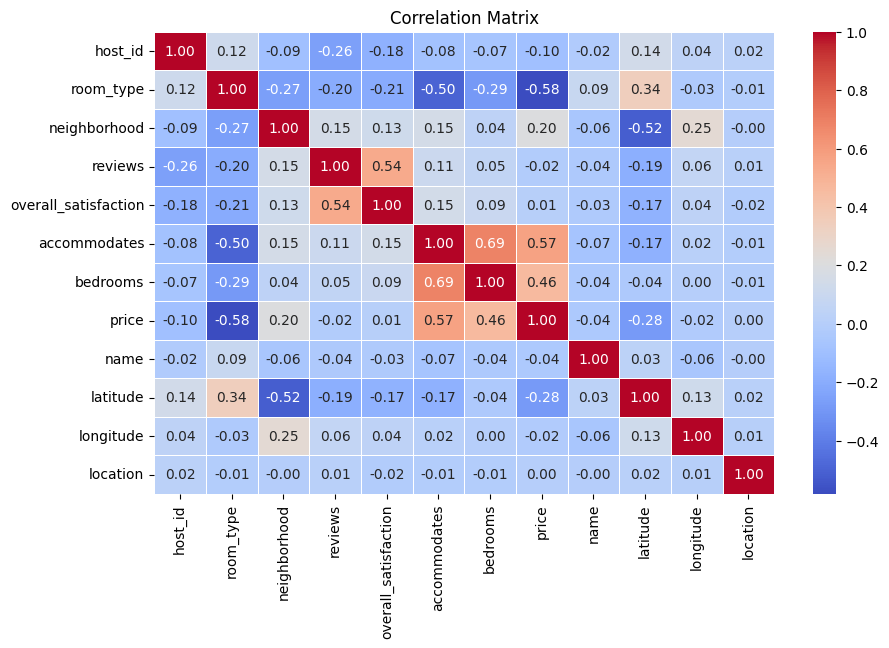

In [248]:
airbnb_data_prep.plot_correlation_matrix()